In [29]:
# =============================================================================
# NOTEBOOK 3: ENTRENAMIENTO Y EVALUACIÓN DE MODELOS
# =============================================================================

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
print("--- Iniciando Notebook de Entrenamiento de Modelos ---")

# --- 1. Carga del Dataset Preprocesado ---
print("Cargando el dataset 'training_data.parquet'...")
try:
    df = pd.read_parquet('training_data.parquet')
    print("Dataset cargado exitosamente.")
    print(f"Dimensiones: {df.shape}")
except FileNotFoundError:
    print("Error: El archivo 'training_data.parquet' no fue encontrado.")
    print("Por favor, ejecuta primero el notebook '01_Data_Preparation.ipynb'.")
    exit()
df = pd.read_parquet('training_data.parquet')

# --- 2. Preparación de Datos para el Modelo (Método Eficiente) ---
print("\nPreparando los datos para el modelado...")
features_to_drop = ['customer_id', 'article_id', 'target']
X = df.drop(columns=features_to_drop)
y = df['target']

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Usamos OrdinalEncoder para convertir las categorías de texto en números enteros.
# Esto es necesario para que DecisionTreeClassifier funcione.
print(f"Aplicando Ordinal Encoding a {len(categorical_features)} columnas categóricas...")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_features] = encoder.fit_transform(X[categorical_features])
print("Codificación completada. Todas las características son ahora numéricas.")






--- Iniciando Notebook de Entrenamiento de Modelos ---
Cargando el dataset 'training_data.parquet'...
Dataset cargado exitosamente.
Dimensiones: (3361236, 18)

Preparando los datos para el modelado...
Aplicando Ordinal Encoding a 11 columnas categóricas...
Codificación completada. Todas las características son ahora numéricas.


In [30]:
# --- 3. División en Train/Test ---
print("Dividiendo los datos en entrenamiento y prueba...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Guardar las columnas del set de entrenamiento
joblib.dump(X_train.columns, 'training_columns.pkl')
print("Columnas del set de entrenamiento guardadas.")

del df
import gc
gc.collect()

Dividiendo los datos en entrenamiento y prueba...
Columnas del set de entrenamiento guardadas.


11760

In [31]:
# --- 4. Entrenamiento y Evaluación de Modelos ---
print("\n--- Entrenando y Evaluando Modelos ---")

# # -- Modelo 1: Regresión Logística (Baseline) --
# print("\nModelo 1: Regresión Logística...")
# log_reg = LogisticRegression(max_iter=1000, random_state=42, solver='saga', n_jobs=-1)
# log_reg.fit(X_train, y_train)
# y_pred_proba_lr = log_reg.predict_proba(X_test)[:, 1]
# auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
# print(f"ROC AUC Score (Regresión Logística): {auc_lr:.4f}")



--- Entrenando y Evaluando Modelos ---


In [32]:
# --- 4. Entrenamiento y Evaluación de Modelos ---
print("\n--- Entrenando y Evaluando Modelos ---")

# -- Modelo 1: Árbol de Decisión (Baseline) --
print("\nModelo 1: Árbol de Decisión (Baseline)...")
# Usamos max_depth para evitar que el árbol crezca indefinidamente y sobreajuste demasiado.
# Un valor entre 5 y 10 es un buen punto de partida para un baseline.
tree_clf = DecisionTreeClassifier(max_depth=8, random_state=42)
tree_clf.fit(X_train, y_train)

print("Evaluando el Árbol de Decisión...")
y_pred_proba_tree = tree_clf.predict_proba(X_test)[:, 1]
auc_tree = roc_auc_score(y_test, y_pred_proba_tree)
print(f"ROC AUC Score (Árbol de Decisión): {auc_tree:.4f}")


--- Entrenando y Evaluando Modelos ---

Modelo 1: Árbol de Decisión (Baseline)...
Evaluando el Árbol de Decisión...
ROC AUC Score (Árbol de Decisión): 0.8989


In [33]:
# -- Modelo 2: LightGBM (Principal) --
print("\nModelo 2: LightGBM...")
lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
lgbm.fit(X_train, y_train, categorical_feature='auto')

print("Evaluando LightGBM...")
y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print(f"ROC AUC Score (LightGBM): {auc_lgbm:.4f}")


Modelo 2: LightGBM...
[LightGBM] [Info] Number of positive: 840309, number of negative: 1680618
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1525
[LightGBM] [Info] Number of data points in the train set: 2520927, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Evaluando LightGBM...
ROC AUC Score (LightGBM): 0.9064


In [34]:
# --- 5. Comparación y Selección del Mejor Modelo ---
print("\n--- Comparación Final de Rendimiento ---")
print(f"AUC Baseline (Árbol de Decisión): {auc_tree:.4f}")
print(f"AUC Principal (LightGBM):         {auc_lgbm:.4f}")

if auc_lgbm > auc_tree:
    print("\nSeleccionando LightGBM como el modelo ganador.")
    modelo_ganador = lgbm
    nombre_modelo_ganador = 'modelo_recomendacion_lgbm.pkl'
else:
    print("\nSeleccionando Árbol de Decisión como el modelo ganador (revisar proceso).")
    modelo_ganador = tree_clf
    nombre_modelo_ganador = 'modelo_recomendacion_tree.pkl'


--- Comparación Final de Rendimiento ---
AUC Baseline (Árbol de Decisión): 0.8989
AUC Principal (LightGBM):         0.9064

Seleccionando LightGBM como el modelo ganador.


In [35]:
# # --- 6. Guardado de Artefactos para Producción ---
# print("Guardando el modelo ganador...")
# joblib.dump(modelo_ganador, 'modelo_recomendacion.pkl')
# print("Modelo guardado exitosamente como 'modelo_recomendacion.pkl'.")
# print("\n--- Notebook de Entrenamiento de Modelos Completado ---")


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86    560206
           1       0.72      0.74      0.73    280103

    accuracy                           0.82    840309
   macro avg       0.80      0.80      0.80    840309
weighted avg       0.82      0.82      0.82    840309


Matriz de Confusión:


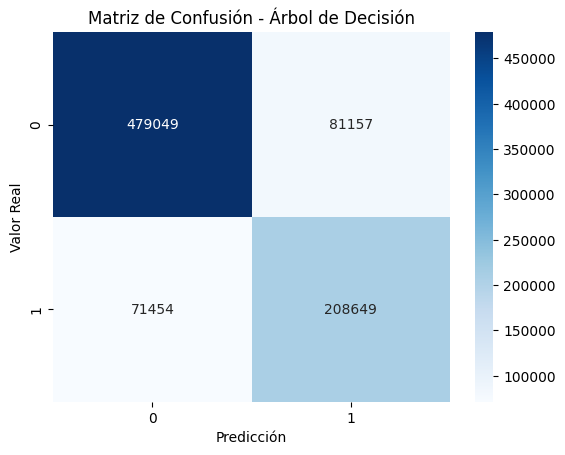

In [36]:
# Predecir clases (0 o 1) para otras métricas
y_pred_tree = tree_clf.predict(X_test)

# Informe de Clasificación
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred_tree))

# Matriz de Confusión
print("\nMatriz de Confusión:")
cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87    560206
           1       0.73      0.75      0.74    280103

    accuracy                           0.83    840309
   macro avg       0.80      0.81      0.81    840309
weighted avg       0.83      0.83      0.83    840309


Matriz de Confusión:


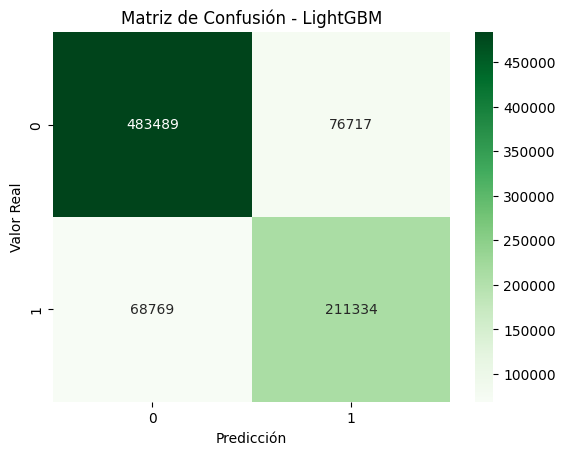

In [37]:
# Predecir clases (0 o 1) para otras métricas
y_pred_lgbm = lgbm.predict(X_test)

# Informe de Clasificación
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred_lgbm))

# Matriz de Confusión
print("\nMatriz de Confusión:")
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - LightGBM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

In [38]:


from sklearn.model_selection import GridSearchCV

print("\n--- Iniciando Ajuste de Hiperparámetros para LightGBM ---")


# Para acelerar, trabajaremos con una muestra del set de entrenamiento
# (Puedes comentar estas líneas si quieres ejecutarlo en el dataset completo durante la noche)
n_samples_for_tuning = 100000  # Usar 100k filas para el ajuste
X_train_sample = X_train.sample(n=n_samples_for_tuning, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# 1. Definir la rejilla de parámetros a probar
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [7, 10],
    'num_leaves': [31, 50]
}
# Número total de combinaciones: 2 * 2 * 2 * 2 = 16

# 2. Instanciar el modelo y GridSearchCV
lgbm_tuner = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

# cv=3 significa validación cruzada de 3 pliegues.
# scoring='roc_auc' le dice que elija la mejor combinación basada en el AUC.
# n_jobs=-1 usará todos los núcleos de tu CPU.
grid_search = GridSearchCV(
    estimator=lgbm_tuner,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2 # Muestra el progreso
)




--- Iniciando Ajuste de Hiperparámetros para LightGBM ---


In [39]:
# 3. Ejecutar la búsqueda
print(f"Ejecutando GridSearchCV con {len(param_grid['n_estimators']) * len(param_grid['learning_rate']) * len(param_grid['max_depth']) * len(param_grid['num_leaves'])} combinaciones...")
grid_search.fit(X_train_sample, y_train_sample)


Ejecutando GridSearchCV con 16 combinaciones...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Number of positive: 22178, number of negative: 44488
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train set: 66666, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332673 -> initscore=-0.696119
[LightGBM] [Info] Start training from score -0.696119
[CV] END learning_rate=0.05, max_depth=7, n_estimators=100, num_leaves=31; total time=   0.1s
[LightGBM] [Info] Number of positive: 22178, number of negative: 44489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if

GridSearchCV(cv=3, estimator=LGBMClassifier(n_jobs=-1, random_state=42),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [7, 10],
                         'n_estimators': [100, 200], 'num_leaves': [31, 50]},
             scoring='roc_auc', verbose=2)

In [40]:
# 4. Obtener los mejores parámetros y el mejor score
print("\nAjuste de hiperparámetros completado.")
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print(f"Mejor ROC AUC Score durante la validación cruzada: {grid_search.best_score_:.4f}")



Ajuste de hiperparámetros completado.
Mejores parámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
Mejor ROC AUC Score durante la validación cruzada: 0.9049


In [41]:
# 5. Entrenar el modelo final con los mejores parámetros en TODO el set de entrenamiento
print("\nEntrenando el modelo final de LightGBM con los mejores parámetros...")
best_params = grid_search.best_params_
lgbm_tuned = lgb.LGBMClassifier(**best_params, random_state=42, n_jobs=-1) # Usamos ** para desempaquetar el diccionario
lgbm_tuned.fit(X_train, y_train)


Entrenando el modelo final de LightGBM con los mejores parámetros...
[LightGBM] [Info] Number of positive: 840309, number of negative: 1680618
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1525
[LightGBM] [Info] Number of data points in the train set: 2520927, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


LGBMClassifier(max_depth=10, n_estimators=200, n_jobs=-1, random_state=42)

In [42]:

# 6. Evaluar el modelo ajustado
print("\nEvaluando el modelo LightGBM AJUSTADO en el conjunto de prueba...")
y_pred_proba_tuned = lgbm_tuned.predict_proba(X_test)[:, 1]
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"ROC AUC Score del modelo por defecto: {auc_lgbm:.4f}")
print(f"ROC AUC Score del modelo AJUSTADO:  {auc_tuned:.4f}")


Evaluando el modelo LightGBM AJUSTADO en el conjunto de prueba...
ROC AUC Score del modelo por defecto: 0.9064
ROC AUC Score del modelo AJUSTADO:  0.9087


In [43]:
# --- 6. Guardado del Modelo Ganador FINAL ---
print("\n--- Guardando el modelo optimizado para producción ---")

# Seleccionamos explícitamente la variable que contiene el modelo ajustado
modelo_final_para_guardar = lgbm_tuned

# Guardamos esa variable en el archivo .pkl
nombre_del_archivo = 'modelo_recomendacion_final.pkl'
joblib.dump(modelo_final_para_guardar, nombre_del_archivo)

print(f"Modelo final (ajustado) guardado exitosamente como '{nombre_del_archivo}'.")
print("\n--- Notebook de Entrenamiento de Modelos Completado ---")


--- Guardando el modelo optimizado para producción ---
Modelo final (ajustado) guardado exitosamente como 'modelo_recomendacion_final.pkl'.

--- Notebook de Entrenamiento de Modelos Completado ---
